In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import glob
import json
import csv
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import findspark
findspark.init()
import pyspark
from pyspark.sql import SQLContext,SparkSession
from pyspark import SparkContext,SparkConf,StorageLevel
from scipy.sparse import csr_matrix
from tqdm import tqdm
from scipy import sparse
from graphframes import *
import re
from nltk.tokenize import sent_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [3]:
# Ref: https://www.kaggle.com/maksimeren/covid-19-literature-clustering

file_path = "/media/jayesh/New Volume/Covid_19_dataset/C19data/metadata.csv"
C19_metadata = pd.read_csv(file_path,dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str })
C19_metadata.head()

/usr/local/anaconda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (1,5,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [4]:
# Getting the path of json files into a list
path = "/media/jayesh/New Volume/Covid_19_dataset/C19data/"
json_paths = glob.glob(f'{path}/**/*.json',recursive=True)
print(json_paths[:5])
print(len(json_paths))

['/media/jayesh/New Volume/Covid_19_dataset/C19data/document_parses/pdf_json/0001418189999fea7f7cbe3e82703d71c85a6fe5.json', '/media/jayesh/New Volume/Covid_19_dataset/C19data/document_parses/pdf_json/0003793cf9e709bc2b9d0c8111186f78fb73fc04.json', '/media/jayesh/New Volume/Covid_19_dataset/C19data/document_parses/pdf_json/000379d7a7f37a2ccb978862b9f2016bd03259ea.json', '/media/jayesh/New Volume/Covid_19_dataset/C19data/document_parses/pdf_json/00039b94e6cb7609ecbddee1755314bcfeb77faa.json', '/media/jayesh/New Volume/Covid_19_dataset/C19data/document_parses/pdf_json/0003ddc51c4291d742855e9ac56076a3bea33ad7.json']
139694


In [5]:
# Reading the data from json files and putting it into a dataframe
covid_data = {'paper_id':[],'title':[],'abstract':[],'text':[]}

for id,each in tqdm(enumerate(json_paths)):
            
    with open(each) as f:
        bodytext = []
        abstract = []
        try:
            content = json.load(f)
            for each_input in content["abstract"]:
                abstract.append(each_input["text"])    
            for each_input in content["body_text"]:
                bodytext.append(each_input["text"])
            bodytext = " ".join(bodytext)
            abstract = " ".join(abstract)
            covid_data['text'].append(bodytext)
            covid_data['abstract'].append(abstract)
            covid_data["paper_id"].append(content["paper_id"])
            covid_data["title"].append(content["metadata"]["title"])
        except:
            continue
       

139694it [02:57, 785.14it/s] 


In [6]:
print(len(covid_data['abstract']))
covid19_df = pd.DataFrame(covid_data)
covid19_df.head()

80744


,paper_id,title,abstract,text
0,0001418189999fea7f7cbe3e82703d71c85a6fe5,Absence of surface expression of feline infect...,Feline infectious peritonitis virus (FIPV) pos...,Feline infectious peritonitis (FIP) is a fatal...
1,0003793cf9e709bc2b9d0c8111186f78fb73fc04,Title: Rethinking high-risk groups in COVID-19,,How do we protect our 'high-risk' patient popu...
2,000379d7a7f37a2ccb978862b9f2016bd03259ea,ScienceDirect ScienceDirect Effect of Nanomate...,approach. The NM shape in the conformal circui...,Integration of functional electronic devices o...
3,00039b94e6cb7609ecbddee1755314bcfeb77faa,Plasma inflammatory cytokines and chemokines i...,Severe acute respiratory syndrome (SARS) is a ...,Severe acute respiratory syndrome (SARS) is a ...
4,0003ddc51c4291d742855e9ac56076a3bea33ad7,Journal Pre-proofs The Fire This Time: The Str...,,It is said that crisis reveals character. The ...


In [7]:
# Treating empty cells
covid19_df['abstract'].replace('',np.nan,inplace=True)
covid19_df['title'].replace('',np.nan,inplace=True)
covid19_df['text'].replace('',np.nan,inplace=True)
covid19_df['paper_id'].replace('',np.nan,inplace=True)
covid19_df.head()
covid19_df.isna().sum()

paper_id        0
title        8527
abstract    25461
text            0
dtype: int64

In [8]:
# Dropping Nan values
covid19_df.dropna(inplace=True)
covid19_df.isna().sum()
covid19_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53091 entries, 0 to 80743
Data columns (total 4 columns):
paper_id    53091 non-null object
title       53091 non-null object
abstract    53091 non-null object
text        53091 non-null object
dtypes: object(4)
memory usage: 2.0+ MB


In [9]:
# Identifying the language of the articles/data (only data in english is considered for analysis)
languages = []
remove = []
from langdetect import detect, DetectorFactory
for index in range(len(covid19_df)):
    try:
        DetectorFactory.seed=0
        languages.append(detect(str(covid19_df['text'].iloc[index][:500])))
    except:
        languages.append("unrec")
        remove.append(index)
        pass    

In [10]:
covid19_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53091 entries, 0 to 80743
Data columns (total 4 columns):
paper_id    53091 non-null object
title       53091 non-null object
abstract    53091 non-null object
text        53091 non-null object
dtypes: object(4)
memory usage: 2.0+ MB


In [11]:
covid19_df['language'] = languages

In [12]:
covid19_df.head()

,paper_id,title,abstract,text,language
0,0001418189999fea7f7cbe3e82703d71c85a6fe5,Absence of surface expression of feline infect...,Feline infectious peritonitis virus (FIPV) pos...,Feline infectious peritonitis (FIP) is a fatal...,en
2,000379d7a7f37a2ccb978862b9f2016bd03259ea,ScienceDirect ScienceDirect Effect of Nanomate...,approach. The NM shape in the conformal circui...,Integration of functional electronic devices o...,en
3,00039b94e6cb7609ecbddee1755314bcfeb77faa,Plasma inflammatory cytokines and chemokines i...,Severe acute respiratory syndrome (SARS) is a ...,Severe acute respiratory syndrome (SARS) is a ...,en
8,00073cb65dd2596249230fab8b15a71c4a135895,Risk Parameters of Fulminant Acute Respiratory...,A clinical picture of patients with acute resp...,"Since then, many clinical case reports have be...",en
10,0008c57de475138d903f2cca7003cf1e1ad93cf4,The effect of gramicidin inclusions on the loc...,We study the local effect of the antimicrobial...,The effect on the cell membrane of inclusions ...,en


In [13]:
covid19_df['language'].value_counts()

en       52192
de         300
fr         231
es         200
nl         101
it          35
pt          11
unrec        5
ca           3
cy           3
pl           3
tl           1
ko           1
id           1
zh-cn        1
sv           1
ru           1
af           1
Name: language, dtype: int64

In [14]:
# Considering only those articles that are in english
covid19_df = covid19_df[covid19_df['language'] == 'en']

In [15]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [16]:
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't", 'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', \
            'al', 'author', 'figure', 'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', \
            'fig.', 'al.', 'Elsevier', 'PMC', 'CZI', 'www']

In [17]:
# The function performs preprocessing on the data
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub("[\(\[].*?[\)\]]", "", sent)
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [18]:
# Performing preprocessing on the text column(i.e. actual data)
preprocessed_text = preprocess_text(covid19_df['text'].values)

100%|██████████| 52192/52192 [17:09<00:00, 50.71it/s] 


In [19]:
covid19_df['preprocessed_text'] = preprocessed_text

In [20]:
covid19_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52192 entries, 0 to 80743
Data columns (total 6 columns):
paper_id             52192 non-null object
title                52192 non-null object
abstract             52192 non-null object
text                 52192 non-null object
language             52192 non-null object
preprocessed_text    52192 non-null object
dtypes: object(6)
memory usage: 2.8+ MB


In [21]:
# Saving dataframe to csv to prevent repeated processing
covid19_df.to_csv('preprocessed_covi19_data.csv')

In [19]:
# Reading from csv
covid19_df = pd.read_csv('preprocessed_covi19_data.csv')

In [20]:
#Taking only a subset of data(i.e.10000 research articles) because of memory limitations
covid19_df_subset = covid19_df[:10000] 
covid19_df_subset.info()
c_data = covid19_df_subset['preprocessed_text'].values
print(len(c_data))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
Unnamed: 0           10000 non-null int64
paper_id             10000 non-null object
title                10000 non-null object
abstract             10000 non-null object
text                 10000 non-null object
language             10000 non-null object
preprocessed_text    10000 non-null object
dtypes: int64(1), object(6)
memory usage: 547.0+ KB
10000


In [21]:
c_title = covid19_df_subset['title'].values

In [22]:
# Using TFIDF vectorizer for converting text to vectors(considering only 10000 features because of memory limitations)
vectorizer_tfidf = TfidfVectorizer(max_features=10000)
vectorizer_tfidf.fit(c_data)
covid_tfidf_text = vectorizer_tfidf.transform(c_data)
print("Data shape:",covid_tfidf_text.shape)

Data shape: (10000, 10000)


In [23]:
print(type(covid_tfidf_text))

<class 'scipy.sparse.csr.csr_matrix'>


In [24]:
# Implementing PCA for dimensionality reduction
pca = PCA(n_components=0.99,svd_solver='full',random_state=42)
covid_tfidf_pca= pca.fit_transform(covid_tfidf_text.toarray())
covid_tfidf_pca.shape

(10000, 6202)

In [26]:
#Ref: https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb

# Finding the optimal values of k using Silhouette Score as a metric
sil_score = []
for k in tqdm(range(2,101)):
    kmeans = KMeans(n_clusters = k).fit(covid_tfidf_pca)
    labels = kmeans.labels_
    sil_score.append(silhouette_score(covid_tfidf_pca, labels, metric = 'euclidean'))    

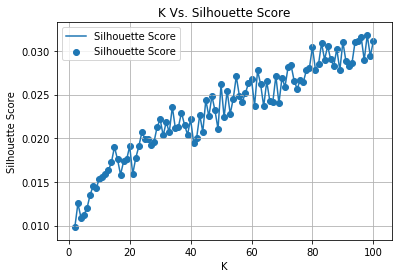

In [13]:
# Plotting the results
plt.plot(range(2,101),sil_score,label="Silhouette Score")
plt.scatter(range(2,101),sil_score,label="Silhouette Score")
plt.title("K Vs. Silhouette Score")
plt.grid()
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.legend()
plt.show()

In [10]:
c_orig_text = covid19_df_subset['text'].values

In [11]:
# Implementing K-means clustering
k = 98 # The optimal value of k (look at the plot)
kmeans = KMeans(n_clusters=k, random_state=2)
y_pred = kmeans.fit_predict(covid_tfidf_pca)

In [12]:
# Creating dataframe containg: Title of research paper,text in research paper, Cluster Number that the paper was assigned to.
ypred = list(y_pred)
cluster_df = pd.DataFrame(list(zip(c_title,c_data,c_orig_text,ypred)),columns=['Title','Text','Original text','Cluster'])
cluster_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
Title            10000 non-null object
Text             10000 non-null object
Original text    10000 non-null object
Cluster          10000 non-null int64
dtypes: int64(1), object(3)
memory usage: 312.6+ KB


In [13]:
# Organise the dataframe based on cluster
sort_df_by_cluster = cluster_df.sort_values('Cluster')

In [14]:
# Save the cluster dataframe to prevent repeated processing
sort_df_by_cluster.to_csv('cluster_df_10000.csv')

In [3]:
# Retrieve from cluster csv file
sort_df_by_cluster = pd.read_csv('cluster_df_10000.csv')
sort_df_by_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
Unnamed: 0       10000 non-null int64
Title            10000 non-null object
Text             10000 non-null object
Original text    10000 non-null object
Cluster          10000 non-null int64
dtypes: int64(2), object(3)
memory usage: 390.7+ KB


In [4]:
print(sort_df_by_cluster['Cluster'].value_counts())

17    691
62    436
40    325
22    272
78    271
27    246
69    242
61    239
5     237
85    227
72    195
96    185
3     182
55    181
87    175
74    171
24    159
11    153
50    147
90    145
37    143
23    139
19    138
56    138
1     134
75    122
66    122
71    122
33    121
26    121
     ... 
38     48
83     48
18     44
48     44
65     41
76     40
8      39
95     39
6      39
82     35
15     35
44     34
81     32
47     30
35     30
77     30
12     27
20     27
97     23
0      22
93     21
45     21
73     20
10     19
68     18
9      15
60     13
7      13
14     12
94     11
Name: Cluster, Length: 98, dtype: int64


In [5]:
wordcloud_stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
                       "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
                       'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
                       'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
                       'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
                       'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
                       'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
                       'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
                       'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
                       'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
                       's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
                       've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
                       "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
                       "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
                       'won', "won't", 'wouldn', "wouldn't", 'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', \
                       'al', 'author', 'figure', 'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', \
                       'fig.', 'al.', 'Elsevier', 'PMC', 'CZI', 'www', 'also', 'may', 'based', 'not', 'first', 'method', 'one', 'two', 'case', 'well', \
                       'could', 'shown', 'might', 'would']

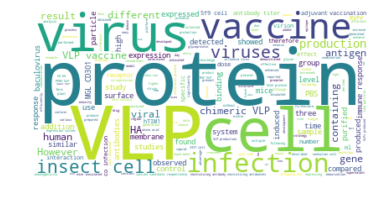

In [17]:
# Implementing WordCloud for each cluster to give user an idea about the cluster text
for j in range(0,1):
    text = " ".join(each for each in sort_df_by_cluster[sort_df_by_cluster["Cluster"]==j]["Original text"].values)    
    wordcloud = WordCloud(stopwords=wordcloud_stopwords, background_color="white").generate(text)
    wc_file = "/home/jayesh/Documents/wordcloud/Cluster_{}_WC.png".format(j)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    wordcloud.to_file(wc_file)    
    
## Output is shown for one cluster

In [8]:
# Function to delete stopwords from text
def stopwords_delete(word_list):
    sent_pp = " ".join([word for word in word_list if word not in stopwords])
    return sent_pp

In [12]:
# Ref: https://www.analyticsvidhya.com/blog/2018/11/introduction-text-summarization-textrank-python/

# This code segment perform text summarization for each cluster using TextRank algorithm 

cluster_wise_sen = {}
cluster_list = [0] # List of clusters for which user want to run TextRank algorithm (Input the cluster number in this list separated by comma)

for i in cluster_list: # for each cluster
    #Using Spark to speed up the computation    
    sc = SparkSession.builder.master("local[*]").appName("spark session example").config("spark.driver.memory", "4g").config("spark.executor.memory", "4g").getOrCreate()
    sentences = []
    tagged_sentences = []
    sentence_in_vector = []
    ranked_sentences = []
    
# Performing sentence tokenizer to break the text into sentences and tag it with its paper title    
    for s in zip(sort_df_by_cluster[sort_df_by_cluster['Cluster']==i]['Original text'].values,sort_df_by_cluster[sort_df_by_cluster['Cluster']==i]['Title'].values):
        t = sent_tokenize(s[0])
        t = [(each,s[1]) for each in t]
        tagged_sentences.append(t)
    tagged_sentences = [y for x in tagged_sentences for y in x]
    sentences = [each[0] for each in tagged_sentences]
       
# Performing basic preprocessing on the entire clustered text     
    preprocessed_sentences = pd.Series(sentences).str.replace("[^A-Za-z0-9]+", " ")
    preprocessed_sentences = [s.lower() for s in preprocessed_sentences]
    preprocessed_sentences = [stopwords_delete(each.split()) for each in preprocessed_sentences]
       
# Converting text to vector using Glove word embeddings    
    for each_line in preprocessed_sentences:
        if len(each_line) != 0:
            sen_vec = sum([word_embeddings.get(i, np.zeros((100,))) for i in each_line.split()])/(len(each_line.split())+0.001)
        else:
            sen_vec = np.zeros((100,))
        sentence_in_vector.append(sen_vec)
    
# Computing similarity score for sentences and implementing PageRank(i.e.TextRank) algorithm to get top ranked sentences   
    final_rdd =  similarity_score_calculation(sentence_in_vector) # RDD containing the similarity scores for sentences
    lst_sent = [(i,s[1],s[0]) for i,s in enumerate(tagged_sentences)]
    vertices = sc.createDataFrame(lst_sent,['id', 'title', 'Sentence']) # Vertices dataframe
    edges = sc.createDataFrame(final_rdd,['src', 'dst','similarity'])   # Edges dataframe
    g = GraphFrame(vertices, edges) # Creating graph from vertices and edges
    g.vertices.show() 
    g.edges.show()
    g.persist(StorageLevel.MEMORY_AND_DISK)
    pr = g.pageRank(tol=0.000001) # Implementing pagerank algorithm on the graph to compute pagerank score
    pr.vertices.show()
    filename = "Cluster_{}_IE.csv".format(i) 
    pr.vertices.coalesce(1).orderBy("pagerank", ascending=False).write.option("header","true").option("sep",",").mode("overwrite").csv(filename) # Saving result to file
    t = []
    sc.stop
    
## The output is shown for one cluster

<class 'scipy.sparse.csr.csr_matrix'>
(5237, 100)
+---+--------------------+--------------------+
| id|               title|            Sentence|
+---+--------------------+--------------------+
|  0|Production of vir...|The vast majority...|
|  1|Production of vir...|These types of va...|
|  2|Production of vir...|Nevertheless, att...|
|  3|Production of vir...|Newer generation ...|
|  4|Production of vir...|                1) .|
|  5|Production of vir...|Subunit vaccines ...|
|  6|Production of vir...|DNA vaccination i...|
|  7|Production of vir...|Virus-like partic...|
|  8|Production of vir...|They are composed...|
|  9|Production of vir...|VLPs are unable t...|
| 10|Production of vir...|Due to the advant...|
| 11|Production of vir...|                2) .|
| 12|Production of vir...|Virus-like partic...|
| 13|Production of vir...|The proteins can ...|
| 14|Production of vir...|In the case of hu...|
| 15|Production of vir...|Other more comple...|
| 16|Production of vir...|VLPs of the 

In [9]:
# Structure of glove file(word followed by its vector representation)
word_embeddings = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_embeddings[word] = coefs
f.close()

In [10]:
# Ref: https://medium.com/@rantav/large-scale-matrix-multiplication-with-pyspark-or-how-to-match-two-large-datasets-of-company-1be4b1b2871e

# Function to parallelize the matrix (Use the link above for detailed explanation)
def parallelize_matrix(matrix, rows_per_group=100):
    [rows, cols] = matrix.shape
    i = 0
    submatrices = []
    while i < rows:
        group_size = min(rows_per_group, rows - i)
        submatrix = matrix[i:i + group_size]
        submatrices.append((i, (submatrix.data, submatrix.indices, 
                                submatrix.indptr),
                            (group_size, cols)))
        i += group_size
    return sc.sparkContext.parallelize(submatrices)

# Function to broadcast the matrix (Use the link above for detailed explanation)
def broadcast_matrix(matrix):
    bcast = sc.sparkContext.broadcast((matrix.data, matrix.indices, matrix.indptr))
    (data, indices, indptr) = bcast.value
    bcast_matrix = csr_matrix((data, indices, indptr), shape=matrix.shape)
    return bcast_matrix

# Function to compute cosine similarity scores
def cosimilarity_in_submatrix(submatrix, fullmatrix, submatrix_start_index,
                              threshold=0):
    cosimilarities = cosine_similarity(submatrix, fullmatrix)
    return list(cosimilarities)

In [11]:
# Convert to float
def convert(x):
    lst = [float(item) for item in x[0]]
    return (x[1],lst)

# This is required to convert each item to form: (source_vertex,destination_vertex,similarity_score),look at the format of edges dataframe
def transform(index,x):
    j = 0
    lst = []
    for each in x:
        lst.append((index,j,each))
        j = j+1
    return lst    

# Computing cosine similarity scores for sentence in a distributed manner using Spark for fast computation
def similarity_score_calculation(sentence_in_vector):
    cluster_summary_dict = {}
    cluster_matrix = np.asmatrix(sentence_in_vector)
    cluster_matrix = sparse.csr_matrix(cluster_matrix)
    print(type(cluster_matrix))
    print(cluster_matrix.shape)
    shp = cluster_matrix.shape[0]
    parallelized_cluster_matrix = parallelize_matrix(cluster_matrix, rows_per_group=100)
    broadcasted_cluster_matrix = broadcast_matrix(cluster_matrix)
    result = parallelized_cluster_matrix.flatMap(
            lambda submatrix:
            list(cosimilarity_in_submatrix(csr_matrix(submatrix[1],
                                                 shape=submatrix[2]),
                                       broadcasted_cluster_matrix,
                                       submatrix[0])))
    new_result = result.map(lambda x: list(x))
    nn_result = new_result.zipWithIndex().map(lambda x: convert(x))
    nng_result = nn_result.flatMap(lambda x:transform(x[0],x[1]))
    final_rdd = nng_result.filter(lambda x: x[2] >= 0.8 and x[0]!=x[1])
        
    return final_rdd